In [1]:
import os
import keras
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=8186)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

In [3]:
# input = np.load("./Detectedface/input.npz")["arr_0"]
# output = np.load("./Detectedface/output.npz")["arr_0"]


input = np.load("./../pre_processing/input20.npz")["arr_0"]
output = np.load("./../pre_processing/output20.npz")["arr_0"]



In [4]:
images = tf.constant(input)
images = tf.reshape(images, [len(input), 1, 200, 200, 3])

images.shape

TensorShape([17279, 1, 200, 200, 3])

(1, 200, 200, 3)
(1, 10, 10, 1200)


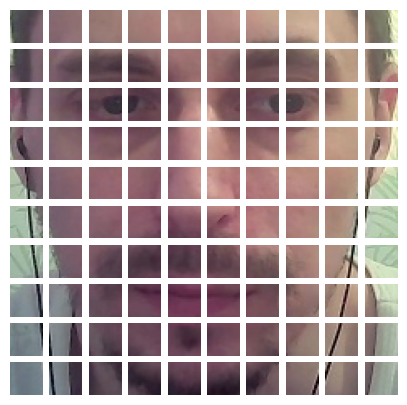

In [5]:
#with tf.device('/cpu:0'):
images = tf.constant(input)

images = tf.reshape(images[0], [1,200,200,3])
print(images.shape)

patches = tf.image.extract_patches(images = images,
                                  sizes= [1,20,20,1],
                                  strides= [1,20,20,1],
                                  rates= [1,1,1,1],
                                  padding='VALID')

print(patches.shape)

plt.figure(figsize=(5,5))
for i in range(10):
    for j in range(10):
        ax = plt.subplot(10,10, (i*10)+j+1)
        plt.imshow(tf.reshape(patches[0][i][j], [20, 20, 3]))
        plt.axis("off")


In [6]:
@keras.saving.register_keras_serializable(package= "PatchEncoder")
class PatchEncoder(Layer):
    def __init__(self, N_PATCHES, HIDDEN_SIZE, **kwargs):
        self.N_PATCHES = N_PATCHES
        self.batch_size = 8
        super(PatchEncoder, self).__init__(name= 'patch_encoder')
        self.linear_projection = Dense(HIDDEN_SIZE)
        self.position_embedding = Embedding(self.N_PATCHES, 256)

    def call(self, x):
        patches = tf.image.extract_patches(images = x,
                                          sizes= [1,20,20,1],
                                          strides= [1,20,20,1],
                                          rates= [1,1,1,1],
                                          padding='VALID')
        patches = tf.reshape(patches, [self.batch_size, self.N_PATCHES, 20 * 20 * 3])
        embedding_input = tf.range(start= 0, limit= self.N_PATCHES, delta= 1) 
        output = self.linear_projection(patches) + self.position_embedding(embedding_input)
        return output


    def get_config(self):
        config = super(PatchEncoder, self).get_config()
        config.update([{"N_PATCHES":self.N_PATCHES,
                       "batch_size":self.batch_size}])
        return config


In [7]:
patch_enc = PatchEncoder(100, 256)
patch_enc(tf.zeros([8 ,200,200,3]))

<tf.Tensor: shape=(8, 100, 256), dtype=float32, numpy=
array([[[ 0.03869415,  0.01470051, -0.0211    , ..., -0.040159  ,
          0.02602461, -0.00446131],
        [ 0.01960567, -0.0107433 ,  0.01524535, ..., -0.02021929,
          0.01127199, -0.00239239],
        [-0.037551  , -0.03387622,  0.00473757, ..., -0.04874113,
          0.0401287 , -0.03672063],
        ...,
        [ 0.0038324 , -0.04790436, -0.01515485, ..., -0.02660359,
         -0.00610197,  0.0397059 ],
        [-0.01657008, -0.03815811,  0.02866881, ..., -0.0079509 ,
         -0.04849339,  0.03410288],
        [ 0.03315084, -0.02033743, -0.0205042 , ...,  0.01874082,
          0.03547936,  0.01021347]],

       [[ 0.03869415,  0.01470051, -0.0211    , ..., -0.040159  ,
          0.02602461, -0.00446131],
        [ 0.01960567, -0.0107433 ,  0.01524535, ..., -0.02021929,
          0.01127199, -0.00239239],
        [-0.037551  , -0.03387622,  0.00473757, ..., -0.04874113,
          0.0401287 , -0.03672063],
        ...,

In [8]:
@keras.saving.register_keras_serializable(package="TransformerEncoder")
class TransformerEncoder(Layer):
    def __init__(self, N_HEADS, HIDDEN_SIZE, **kwargs):
        super(TransformerEncoder, self).__init__(name='transformer_encoder')
        self.norm_layer1 = LayerNormalization()
        self.norm_layer2 = LayerNormalization()
        self.N_HEADS = N_HEADS
        self.HIDDEN_SIZE = HIDDEN_SIZE
        self.muti_head_a = MultiHeadAttention(self.N_HEADS, self.HIDDEN_SIZE)

        self.dens1 = Dense(self.HIDDEN_SIZE, activation= tf.nn.gelu)
        self.dens2 = Dense(self.HIDDEN_SIZE, activation= tf.nn.gelu)

    def call(self, input):
        x_1 = self.norm_layer1(input)
        x_1, self.attention_weigth = self.muti_head_a(x_1, x_1, return_attention_scores=True)
        x_1 = Add()([x_1, input])

        x_2 = self.norm_layer2(x_1)
        x_2 = self.dens1(x_2)
        output = self.dens2(x_2)
        output = Add()([output, x_1])

        return output

    def get_config(self):
        config = super(TransformerEncoder, self).get_config()
        config.update([{"N_HEADS":self.N_HEADS,
                       "HIDDEN_SIZE":self.HIDDEN_SIZE}])
        return config

In [9]:
trans_enc = TransformerEncoder(4, 256 )
trans_enc(tf.ones([8,100, 256]))
trans_enc.attention_weigth

<tf.Tensor: shape=(8, 4, 100, 100), dtype=float32, numpy=
array([[[[0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
         [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
         [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
         ...,
         [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
         [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
         [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01]],

        [[0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
         [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
         [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
         ...,
         [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
         [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
         [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01]],

        [[0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
         [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
         [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
         ...,
         [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
         [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
         [0.

In [10]:
@keras.saving.register_keras_serializable(package="VIT")
class VIT(Model):
    def __init__(self, N_HEADS, HIDDEN_SIZE, N_PATCHES, N_LAYERS, N_DENSE_UNITS, **kwargs):
        super(VIT, self).__init__(name=  'vision_transformer')

        self.N_LAYERS = N_LAYERS
        self.dense1 = Dense(N_DENSE_UNITS, activation=tf.nn.gelu)
        self.dense2 = Dense(N_DENSE_UNITS, activation=tf.nn.gelu)
        self.dense3 = Dense(4, activation= 'softmax')
        self.patch_encoder = PatchEncoder(N_PATCHES, HIDDEN_SIZE ) 
        #self.trans_encoder = TransformerEncoder(N_HEADS, HIDDEN_SIZE)
        self.trans_encoders = []
        for _ in range(N_LAYERS):
            self.trans_encoders.append(TransformerEncoder(N_HEADS, HIDDEN_SIZE))

    def call(self, input, training = True):

        x = self.patch_encoder(input)

        #x = self.trans_encoder(x)

        for i in range(self.N_LAYERS):
            x = self.trans_encoders[i](x)

        x = Flatten()(x)
        x = self.dense1(x)
        x = self.dense2(x)
        
        return self.dense3(x)
        
    def get_config(self):
        config = super(VIT, self).get_config()
        config.update([{"N_LAAYERS":self.N_LAYERS,
                       "Transformers_encoders": self.trans_encoders}])
        return config

In [11]:
vit = VIT(8, 256, 100, 1,  256)
vit(tf.zeros([8, 200, 200, 3]))

vit.summary()

Model: "vision_transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (8, 256)                    │       6,553,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (8, 256)                    │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (8, 4)                      │           1,028 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patch_encoder (PatchEncoder)         │ ?                           │         333,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder                  │ ?                           │       2,236,160 │
│ (TransformerEncoder)                 │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,189,892 (35.06 MB)

 Trainable params: 9,189,892 (35.06 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# 1 Label and index 1 array for real images, zero values and index 0 for imposter images. 

output_data = np.zeros([len(output),4])
for i in range(len(output)):
    value = output[i]
    output_data[i][value] = 1
    
print(output[1])    
print(output_data.shape)
print(input.shape)

# input = np.reshape(input[:-7], (2159, 8 , 200, 200, 3))
# output_data = np.reshape(output_data[:-7], (2159, 8 , 4))

0
(17279, 4)
(17279, 200, 200, 3)


In [13]:
### ["real", "mask", "print", "screen"] ###
vit.compile(
optimizer = Adam(10e-6),
loss = CategoricalCrossentropy(),
metrics=["accuracy"]
)

vit.fit(
    input[:15000],
    output_data[:15000],
    validation_data=(input[15000:-7], output_data[15000:-7]),
    #class_weight= {0:2, 1: 3, 2:2, 3:4},
    epochs=3,
    verbose=1,
    batch_size=8
)

Epoch 1/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 240s 126ms/step - accuracy: 0.4721 - loss: 22.0459 - val_accuracy: 0.5858 - val_loss: 7.3248
Epoch 2/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 235s 125ms/step - accuracy: 0.6455 - loss: 4.8770 - val_accuracy: 0.7210 - val_loss: 3.0045
Epoch 3/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 232s 124ms/step - accuracy: 0.7219 - loss: 2.8012 - val_accuracy: 0.7399 - val_loss: 2.8804


In [18]:
# vit.save("vit_four_class_01.keras")
#vit.save_weights("vit_four_class_21_w.weights.h5")


In [14]:
vit.predict(np.zeros((8,200,200,3)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


array([[0.30834797, 0.26616946, 0.21540572, 0.2100768 ],
       [0.30834797, 0.26616946, 0.21540572, 0.2100768 ],
       [0.30834797, 0.26616946, 0.21540572, 0.2100768 ],
       [0.30834797, 0.26616946, 0.21540572, 0.2100768 ],
       [0.30834797, 0.26616946, 0.21540572, 0.2100768 ],
       [0.30834797, 0.26616946, 0.21540572, 0.2100768 ],
       [0.30834797, 0.26616946, 0.21540572, 0.2100768 ],
       [0.30834797, 0.26616946, 0.21540572, 0.2100768 ]], dtype=float32)

In [15]:
#vit.trans_encoder(tf.random.normal([8,100,256]))
vit.trans_encoders[0](vit.patch_encoder(input[8:16]))
a_w = vit.trans_encoders[0].attention_weigth
#plt.imshow(a_w[0,0,0])

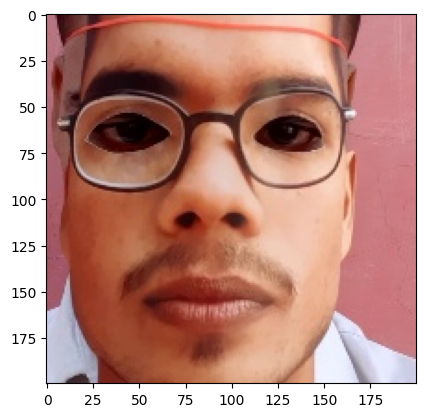

In [16]:
plt.imshow(input[8])

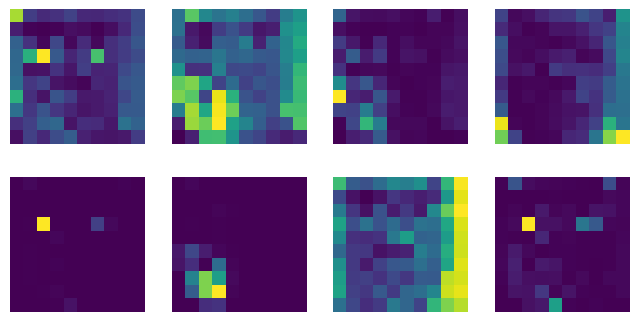

In [17]:
# array = np.zeros((100,100))

# for i in a_w[0][2]:
#     array = np.add(array, i)


# plt.imshow(np.resize(array, (10,10)))


plt.figure(figsize=(8,4))
for i in range(2):
    for j in range(4):
        ax = plt.subplot(2,4, (i*4)+j+1)
        array = np.zeros((100,100))
        for a in a_w[0][i*4+j]:
            array = np.add(array, a)

        plt.imshow(np.resize(array, (10, 10)))
        plt.axis("off")


In [18]:
vit.predict(input[:8])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


array([[9.9999857e-01, 1.5461941e-13, 1.4079662e-06, 1.2376339e-09],
       [1.0000000e+00, 4.2398124e-15, 2.5359486e-13, 3.7715400e-09],
       [4.6296595e-11, 9.9739897e-01, 2.6010694e-03, 1.5522524e-13],
       [6.5367506e-10, 8.0299232e-24, 1.3177041e-10, 1.0000000e+00],
       [2.5185637e-04, 3.5583456e-21, 7.1017277e-01, 2.8957531e-01],
       [4.9600484e-08, 1.6440179e-03, 9.9835545e-01, 5.5154345e-07],
       [1.7072742e-13, 5.9892878e-26, 1.0000000e+00, 5.7739680e-10],
       [9.7263002e-01, 3.7586764e-05, 2.7257148e-02, 7.5227646e-05]],
      dtype=float32)

In [19]:
output[:8]

array([0, 0, 1, 3, 0, 1, 2, 0])